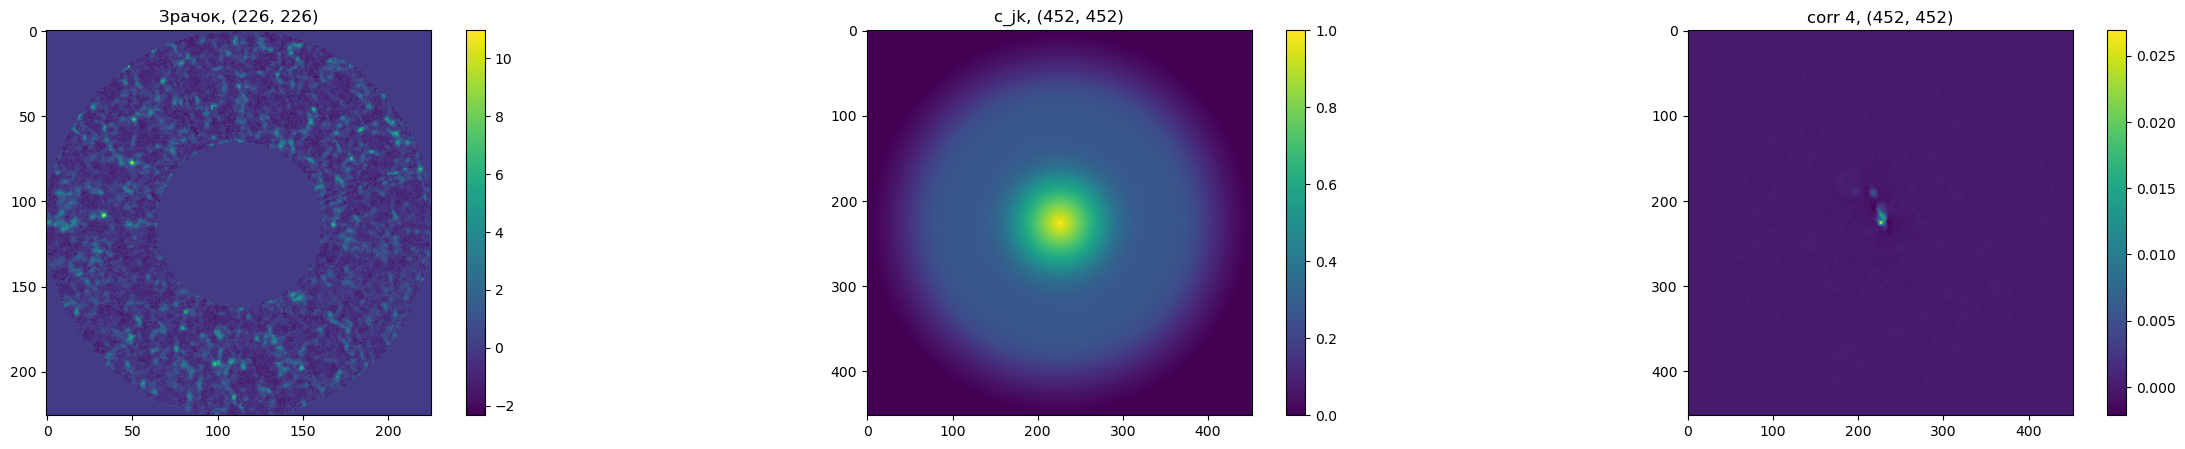

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import shift
from scipy.optimize import curve_fit
from skimage.filters import threshold_multiotsu, threshold_otsu, median

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    if idx == (len(array) - 1):
        return idx, idx-1
    if idx == 0:
        return 1, 0
    else:
        if array[idx] > value:
            return idx, idx-1 
        if array[idx] < value:
            return idx+1, idx

def gamma_poly_se(X, Y, Vx, Vy, Cn2, z): 
    global cjk, t, a1, gammas, delta
    
    Cn2=Cn2*1e-14
    z=z*1000

    # мб дать как то обозначить приоритетность выбора? или че нибудь такое. или шаг типа сделать равнозначный как по
#     высоте, так и по мощности
    
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    
    lv = find_nearest(a1, z)[1]
    uv = find_nearest(a1, z)[0]
    
    res = gammas[lv] + (z - a1[lv])*((gammas[uv] - gammas[lv])/(a1[uv] - a1[lv]))
    
    res = (res/(1e-13))*Cn2
    res = shift(res, (-Ypix, Xpix), order=1)  

    res = res * cjk
    return res

# ----------- входные параметры
D = 2.5
latency = 4
z0 = 'm2' #  '0' or m2'
data_dir = 'D:/astro/domecam'
file = '20210130e'
gammas_type = 'blur'
lambda_=500*pow(10, -9) # нм


sec_per_frame = 0.01
t = sec_per_frame * latency
k = 2*np.pi/lambda_

# ---------- считывание зрачка, картины мерцаний, автокорреляции зрачка и гамм

if gammas_type == 'orig':
    print('lol')

if gammas_type == 'blur':
    data = np.loadtxt(f'{data_dir}/{file}_{z0}km_corr_{latency}_blur.gz')
    gammas = np.load(f'{data_dir}/gammas_blur.npy')

pupil = np.loadtxt(f'{data_dir}/frame.gz')
cjk = np.loadtxt(f'{data_dir}/cjk.gz')
a1 = np.loadtxt(f'{data_dir}/z.gz')

# ------------ шаг для функции гамма
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y)

delta = D/(pupil.shape[0]) # шаг по пикселю

# ------------------ распределение гамм


fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))

fig.colorbar(ax.imshow(pupil), ax = ax)
ax.grid(False)
ax.set_title(f'Зрачок, {pupil.shape}')

fig.colorbar(ax2.imshow(cjk), ax=ax2)
ax2.grid(False)
ax2.set_title(f'c_jk, {cjk.shape}')

fig.colorbar(ax3.imshow(data), ax=ax3)
ax3.grid(False)
ax3.set_title(f'corr 4, {data.shape}')

def CLEAN(dirty, gain=None, thresh=None, niter=None, window=None):
    global t, delta
    st = time.perf_counter()
    comps = np.zeros(dirty.shape)
    res = np.array(dirty) 
    cl = np.zeros(dirty.shape)
    
    k = 5
    res2 = np.array(dirty)
    cl2 = np.zeros(dirty.shape)

    tmp = 0
    tmp_Vx = []
    tmp_Vy = []
    all_params = []
    all_errors = []
    for i in range(niter):
        my, mx = np.unravel_index(np.argmax(res), res.shape)
        mval=res[my, mx]*gain
        comps[my, mx]+=mval
        
        Vy = (dirty.shape[0]//2-my)*delta/t
        Vx = -(dirty.shape[1]//2-mx)*delta/t
        
        tmp_Vx.append(Vx)
        tmp_Vy.append(Vy)
                
        if i > 5\
        and tmp_Vx[i-4] == tmp_Vx[i] and tmp_Vx[i-3] == tmp_Vx[i] and tmp_Vx[i-2] == tmp_Vx[i] and tmp_Vx[i-1] == tmp_Vx[i]\
        and tmp_Vy[i-4] == tmp_Vy[i] and tmp_Vy[i-3] == tmp_Vy[i] and tmp_Vy[i-2] == tmp_Vy[i] and tmp_Vy[i-1] == tmp_Vy[i]:
            all_params = np.array(all_params)
            all_params = all_params[:-4, :]
            all_errors = np.array(all_errors)
            all_errors = all_errors[:-4, :]
            reason = 'Stucked!'
            print('Stucked!')
            break
        
        if int(Vx) == 0 and int(Vy) == 0:
            print('\nDome turbulence')
            p0_Cn2 = (res[my, mx]/np.max(gamma_poly_se(X, Y, Vx, Vy, 10, 2))) * 10
            myParams = [0, 0, p0_Cn2, 2]
            psf, params, errors = multi_speckle_fit(myParams, ydata=res, window=window//2)
            print('test Cn2:', p0_Cn2)
            print('-initial value:', res[my, mx])
            res -= psf*0.99
        else:
            p0_Cn2 = (res[my, mx]/np.max(gamma_poly_se(X, Y, Vx, Vy, 10, 15))) * 10
            myParams = [Vx, Vy, p0_Cn2, (15+5*np.sin(np.random.uniform(-np.pi, np.pi)))]  
            psf, params, errors = multi_speckle_fit(myParams, ydata=res, window=window)
            print('test Cn2:', p0_Cn2)
            print('-initial value:', res[my, mx])
            res -= psf*gain
        
        cl += psf*gain
        all_params.append(params)
        all_errors.append(errors)
        print('-residual value:', res[my, mx])
        
        if (i+1)%k == 0:
            print('\nCheckpoint fitting...')
#             fit, params2 = one_speckle_fit(all_params[i-(k-1):i+1], res2)
#             res2 -= fit
#             cl2 += fit
            
#             plt.figure()
#             plt.imshow(res2)
#             plt.show()
            
#             plt.figure()
#             plt.imshow(cl2)
#             plt.show()
        print(' ')
        
        tmp = i
        if np.max(res) < thresh:
            reason = 'Thresh reached!'
            print('Thresh reached!')
            break
    print('Total iterations:', tmp+1)
    print('time:', time.perf_counter()-st)
    conf = [reason, tmp+1, time.perf_counter()-st]
    return comps, res, cl, np.array(all_params), np.array(all_errors), conf


def multi_speckle_fit(params, ydata=None, window=None):
    global t, delta
    st=time.perf_counter()  
    def speckle_fit(params, ydata, window=None):
        k=window
        def _g(one_dim_x, *args): 
            arr = np.zeros(one_dim_x[0].shape)
            Vx = args[0]
            Vy = args[1]
            Cn2 = args[2]
            z = args[3]
            arr += gamma_poly_se(one_dim_x[0], one_dim_x[1], Vx, Vy, Cn2, z)[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k].ravel()
#             arr += gamma_poly_se(one_dim_x[0], one_dim_x[1], Vx, Vy, Cn2, z).ravel()
            return arr
        
        xcoord = params[0]
        ycoord = params[1]
        cr = ydata.shape[0]//2, ydata.shape[1]//2
        
        Xpix1 = int(xcoord*t/delta) + cr[1]
        Ypix1 = -int(ycoord*t/delta) + cr[0]
        
        fit = np.zeros(ydata.shape)
        ydata = ydata[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]
        
        plt.figure()
        plt.imshow(ydata)
        plt.colorbar()
        plt.show()
        
        x = np.linspace(-ydata.shape[1]//2, ydata.shape[1]//2-1, ydata.shape[1])
        y = np.linspace(-ydata.shape[0]//2, ydata.shape[0]//2-1, ydata.shape[0])
        X, Y = np.meshgrid(x, y)
        
        xdata = np.vstack((X.ravel(), Y.ravel()))
        
        ydata = ydata.ravel()

        bounds = [[-np.inf, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf]]
#         bounds = [[-np.inf, -np.inf, params[2]-0.01, 0], [np.inf, np.inf, params[2]+0.01, np.inf]]
        popt, pcov = curve_fit(_g, xdata, ydata, p0=params, bounds=bounds)
        
        fit += gamma_poly_se(X, Y, *popt)        

        return fit, popt[0], popt[1], popt[2], popt[3], np.sqrt(np.diag(pcov))
        
    res = np.zeros(data.shape)
    print(f'Speckle fitting: {params[0]} {params[1]} {1e-14*params[2]} {1000*params[3]}')
    fit, Vx, Vy, Cn2, z, errors = speckle_fit(params, ydata, window=window)
    
    xcoord = int(Vx*t/delta)
    ycoord = int(Vy*t/delta)
    res +=fit        
    print(f'Fitted parametrs: {Vx:.2f} {Vy:.2f} {1e-14*Cn2} {1000*z}')
    print('time:', time.perf_counter()-st)    
    return res, [Vx, Vy, Cn2, z], errors

def one_speckle_fit(params=None, data=None): 
    def _g(M, *args): 
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//4):
            arr += gamma_poly_se(x, y, *args[i*4:i*4+4]).ravel()
        return arr
        
    p0 = [p for prms in params for p in prms]
        
    st=time.perf_counter()
       
    x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
    y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
    X, Y = np.meshgrid(x, y)

    fit = np.zeros(X.shape) 
    xdata = np.vstack((X.ravel(), Y.ravel())) 
    ydata = data.ravel()
        
    lb = [-np.inf, -np.inf, 0, 0]
    lb = np.tile(lb, len(p0)//4)
    ub = [np.inf, np.inf, np.inf, np.inf]
    ub = np.tile(ub, len(p0)//4)
        
    popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[lb, ub])

    for i in range(len(popt)//4):
        fit += gamma_poly_se(X, Y, *popt[i*4:i*4+4])

    print(f'Time: {time.perf_counter()-st:.4f}')

    for i in range(len(popt)//4):
        print(*popt[i*4:i*4+4])

    return fit, popt

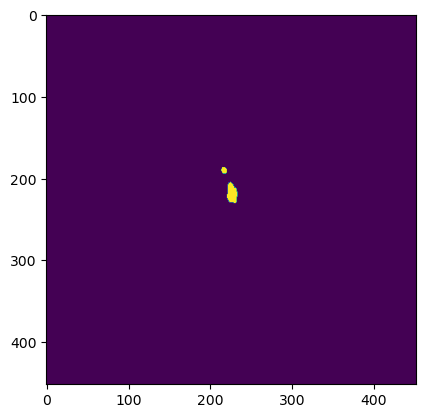

In [2]:
gain=1
niter=50
window=10
thresh_type = 'multiotsu'

if thresh_type == 'otsu':
    thresh = threshold_otsu(data)
if thresh_type == 'multiotsu':
    thresh = threshold_multiotsu(data)[0]

plt.imshow(data>thresh)


Dome turbulence
Speckle fitting: 0 0 3.3339750842970644e-13 2000


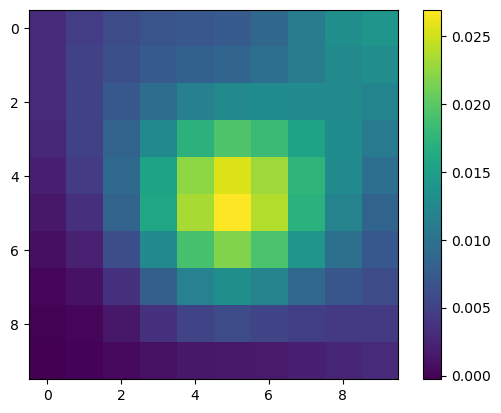

Fitted parametrs: 0.16 0.31 4.598152817874407e-14 10283.43336249105
time: 0.7486960999999965
test Cn2: 33.339750842970645
-initial value: 0.026919595897197723
-residual value: 0.006822755129108318
 
Speckle fitting: 0.27654867256637167 2.4889380530973453 2.5257239666015395e-14 19959.231092361988


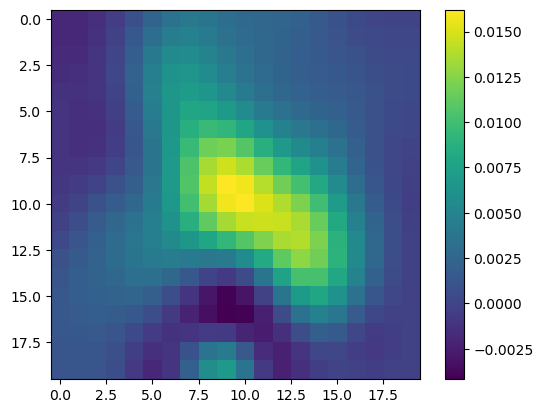

Fitted parametrs: 0.35 2.77 1.4436600229838155e-14 22329.526873111317
time: 0.5753360000000001
test Cn2: 2.5257239666015394
-initial value: 0.01620546260878794
-residual value: 0.0034214671404525915
 

Dome turbulence
Speckle fitting: 0 0 8.949554661303312e-14 2000


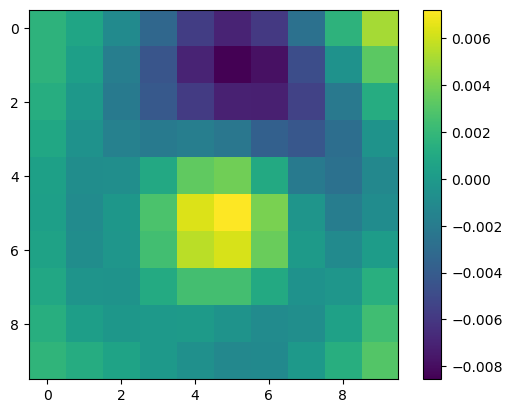

Fitted parametrs: -0.11 -0.12 2.759704117959835e-13 1010.100652460064
time: 1.2537669999999963
test Cn2: 8.949554661303312
-initial value: 0.007226160629600585
-residual value: 0.0007346569664381068
 
Speckle fitting: 1.3827433628318584 1.65929203539823 9.660536928283913e-15 11211.494664277643


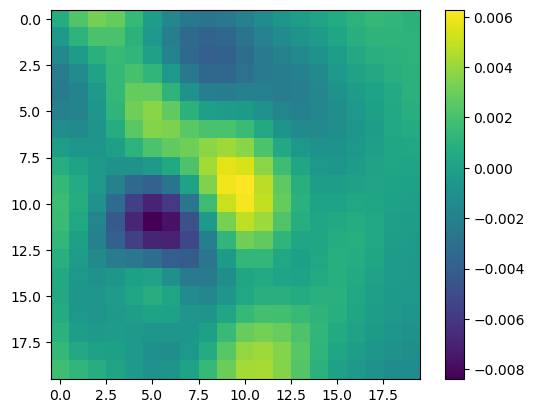

Fitted parametrs: 1.38 1.72 3.245666406194775e-14 4027.3415038957287
time: 1.1160276999999965
test Cn2: 0.9660536928283913
-initial value: 0.006280902723374842
-residual value: 0.0008195422413099828
 
Speckle fitting: -2.4889380530973453 9.679203539823009 1.2955074635179496e-14 17144.761341604142


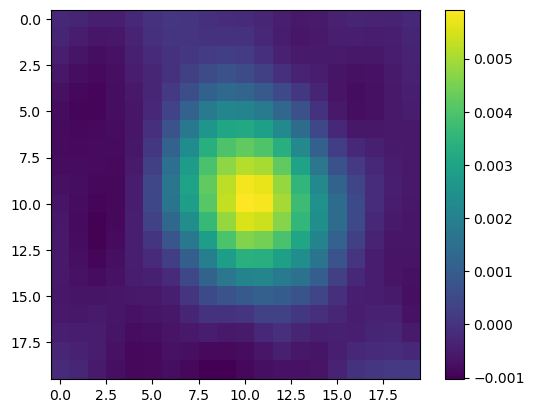

Fitted parametrs: -2.42 9.82 1.9359168155883434e-14 10372.494711327316
time: 0.4944778999999997
test Cn2: 1.2955074635179495
-initial value: 0.00591868429729725
-residual value: -4.4739679441161556e-05

Checkpoint fitting...
 
Speckle fitting: 1.65929203539823 -1.1061946902654867 6.654738130274595e-15 17762.459393654644


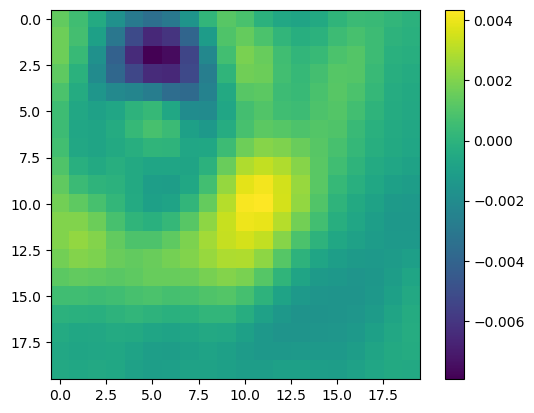

Fitted parametrs: 1.52 -1.14 1.094861488230135e-14 8051.64443101064
time: 0.9292826000000005
test Cn2: 0.6654738130274594
-initial value: 0.004353508595017425
-residual value: 0.0005915884173866735
 
Speckle fitting: -0.829646017699115 4.701327433628318 7.22836809433815e-15 13757.074029815461


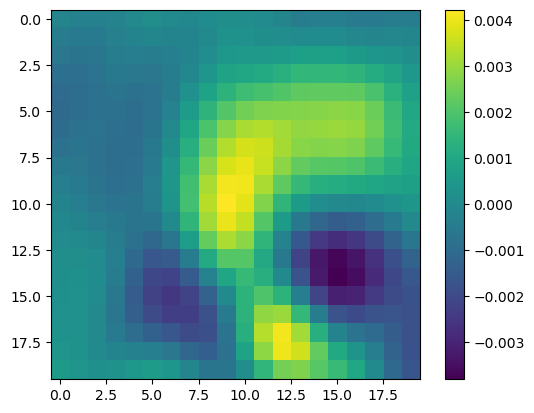

Fitted parametrs: -0.20 5.58 9.209540146110913e-15 11616.178416693014
time: 0.9691037999999992
test Cn2: 0.722836809433815
-initial value: 0.004227081173790489
-residual value: 0.002379168717976014
 
Speckle fitting: 0.0 2.765486725663717 7.0155131519955346e-15 19891.86144353125


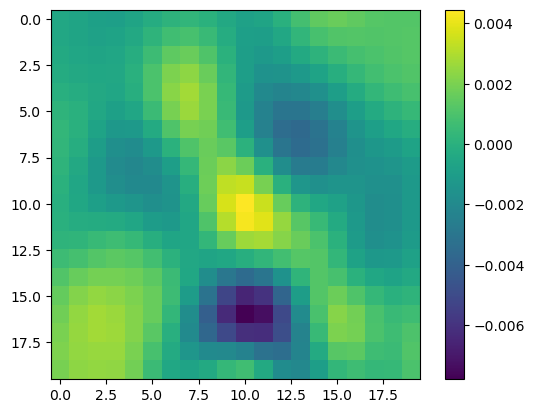

Fitted parametrs: 0.02 2.68 5.083959656204811e-14 2525.253176076275
time: 1.1406857999999929
test Cn2: 0.7015513151995535
-initial value: 0.004456538190310828
-residual value: -0.00019556387215224728
 
Speckle fitting: -0.829646017699115 4.424778761061947 4.7199451063419074e-15 17417.27971548421


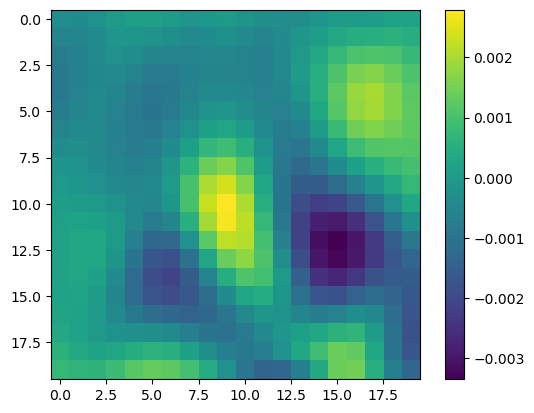

Fitted parametrs: -0.83 4.42 9.733289221897388e-15 5021.965966200948
time: 1.3460687000000036
test Cn2: 0.47199451063419073
-initial value: 0.002792198877075952
-residual value: 0.0008482319750425583
 
Speckle fitting: -2.2123893805309733 1.1061946902654867 4.316496685508302e-15 10234.663357125748


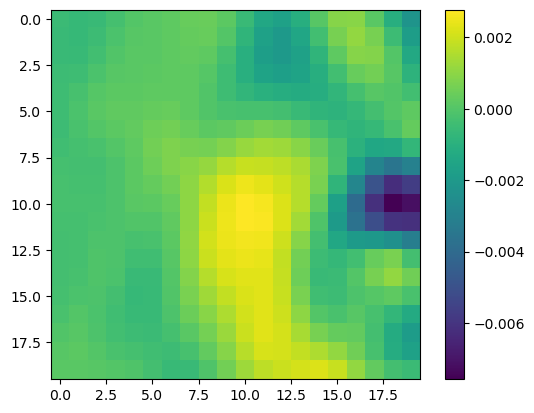

Fitted parametrs: -2.22 0.64 8.011127366088772e-15 9090.909830867924
time: 1.1120217999999937
test Cn2: 0.4316496685508302
-initial value: 0.0027720376548162826
-residual value: 0.00015898408522262803

Checkpoint fitting...
 
Speckle fitting: -1.1061946902654867 -1.65929203539823 4.221995446248691e-15 19510.09242733226


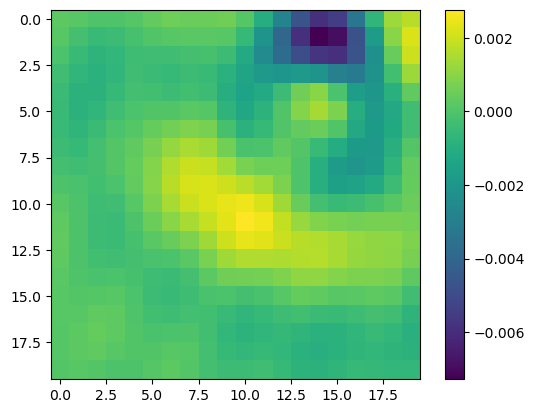

Fitted parametrs: -1.25 -1.46 5.571452851890723e-15 9891.883251835676
time: 0.8146131999999966
test Cn2: 0.4221995446248691
-initial value: 0.0027625598696741234
-residual value: 0.0004905547662540028
 
Thresh reached!
Total iterations: 11
time: 10.625386500000005


Text(0.5, 1.0, 'max: 0.0022, min: -0.0071')

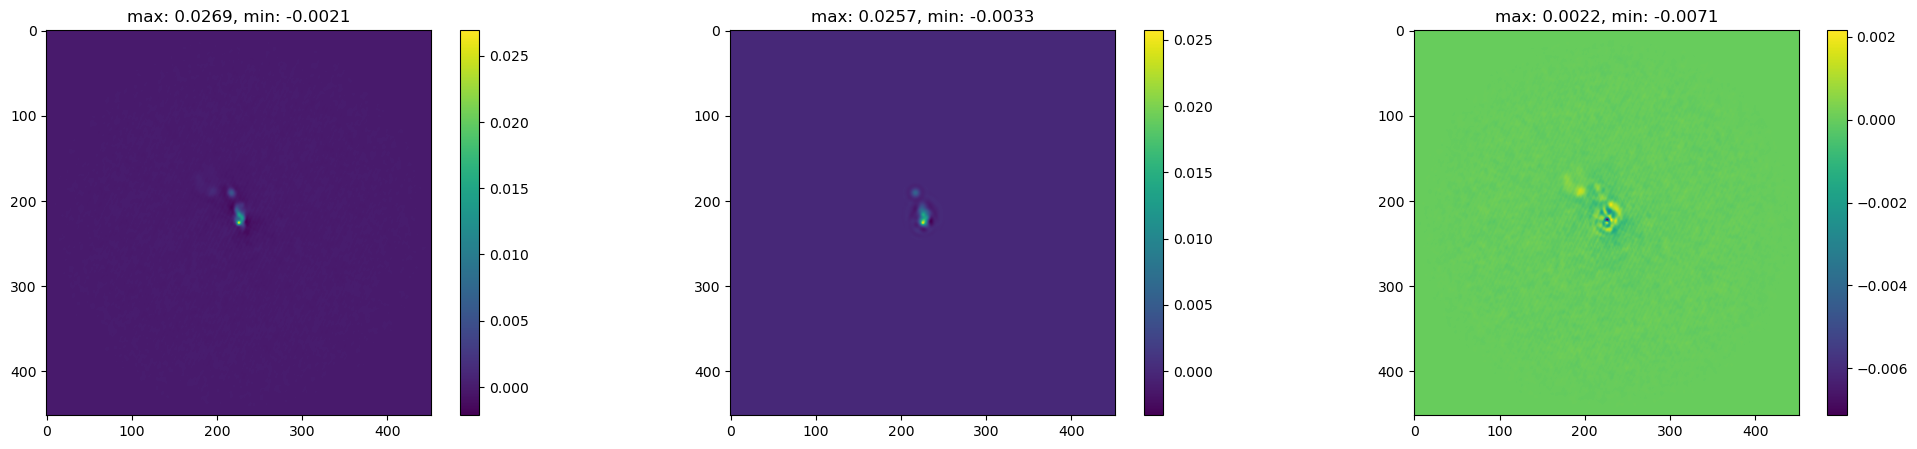

In [3]:
comps, residual, clean, params, errors, conf = CLEAN(data, gain=gain, thresh=thresh, niter=niter, window=window)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
fig.colorbar(ax.imshow(data), ax=ax) 
fig.colorbar(ax2.imshow(clean), ax=ax2) 
fig.colorbar(ax3.imshow(residual), ax=ax3) 
ax.set_title(f'max: {np.max(data):.4f}, min: {np.min(data):.4f}') 
ax2.set_title(f'max: {np.max(clean):.4f}, min: {np.min(clean):.4f}') 
ax3.set_title(f'max: {np.max(residual):.4f}, min: {np.min(residual):.4f}')

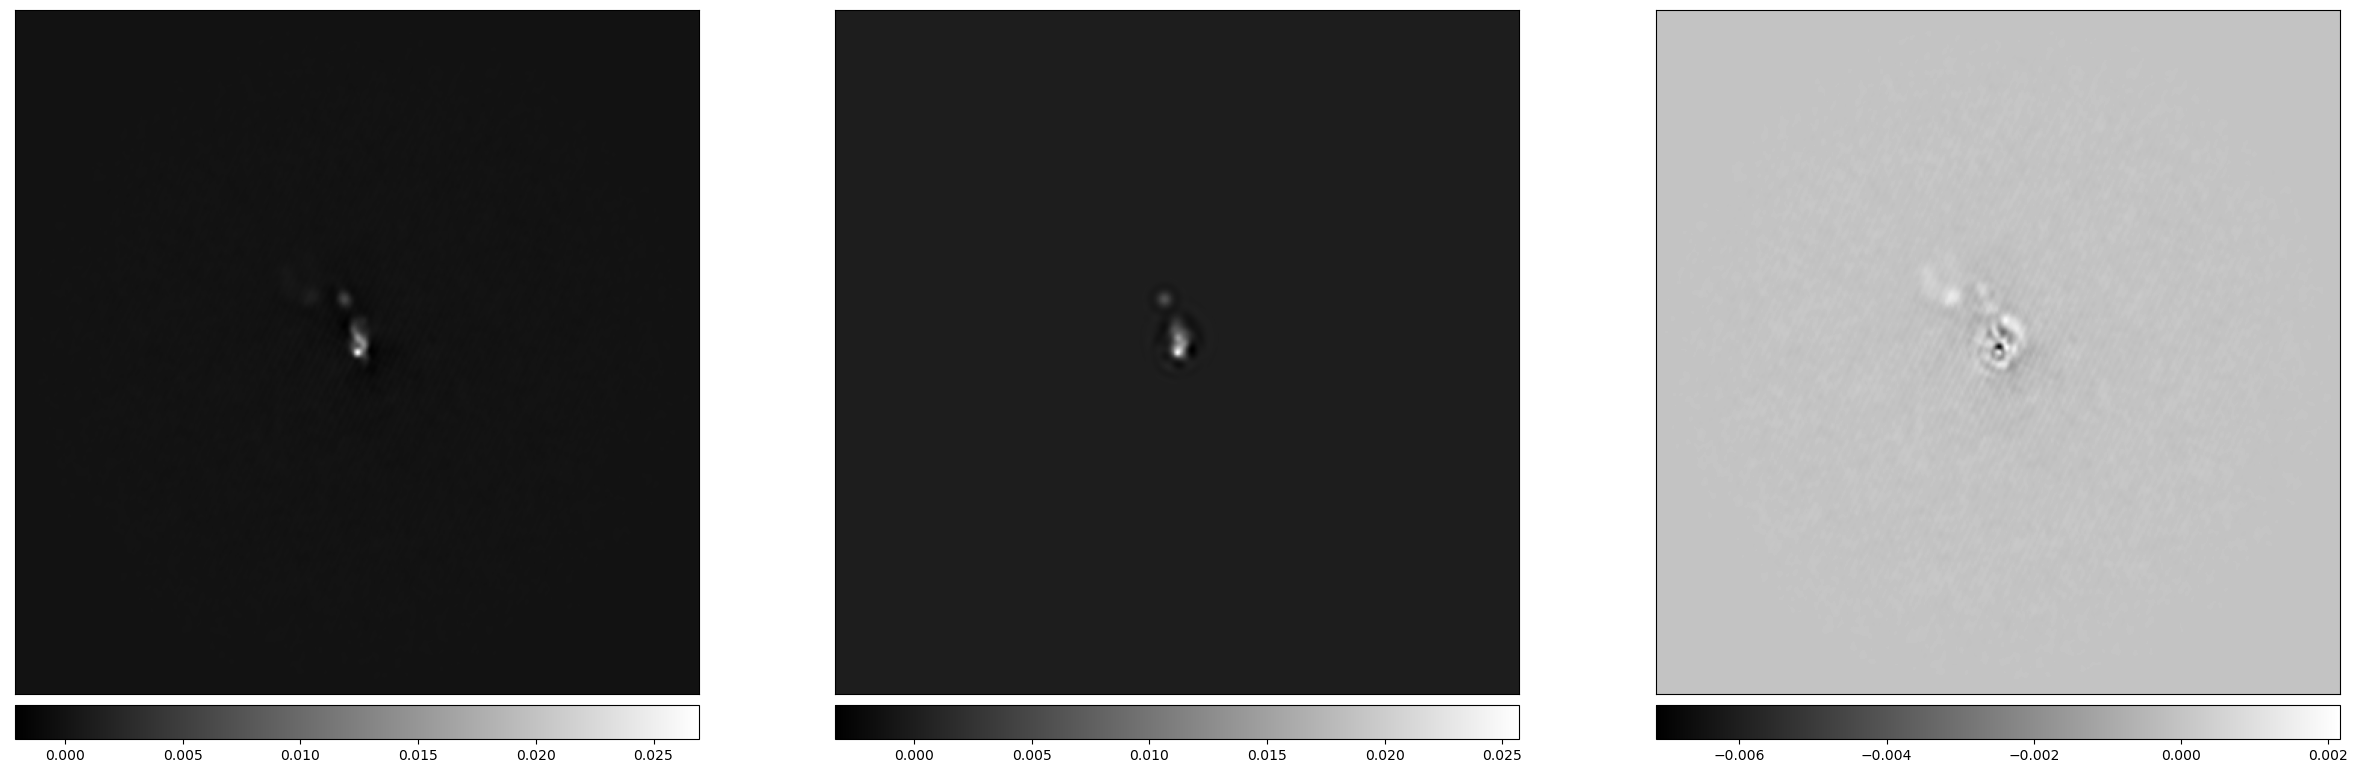

In [5]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 15)) 
fig.colorbar(ax.imshow(data, cmap='gray'), orientation="horizontal", pad=0.01, ax=ax) 
fig.colorbar(ax2.imshow(clean, cmap='gray'), orientation="horizontal", pad=0.01, ax=ax2) 
fig.colorbar(ax3.imshow(residual, cmap='gray'), orientation="horizontal", pad=0.01, ax=ax3) 

ax.set_xticks([])
ax.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])

fig.savefig(f'D:/astro/fitting_{file}_{z0}_{latency}.png', bbox_inches='tight')

          Vx        Vy        Cn2          z
2  -0.113348 -0.120905  27.597041   1.010101
7   0.022026  2.680130   5.083960   2.525253
3   1.382743  1.719470   3.245666   4.027342
8  -0.829646  4.420797   0.973329   5.021966
5   1.517350 -1.144285   1.094861   8.051644
9  -2.218413  0.638361   0.801113   9.090910
10 -1.253931 -1.456237   0.557145   9.891883
0   0.161070  0.306823   4.598153  10.283433
4  -2.415218  9.817505   1.935917  10.372495
6  -0.195188  5.578412   0.920954  11.616178
1   0.351378  2.766992   1.443660  22.329527
      err_Vx    err_Vy     err_Cn2     err_z
0   0.029122  0.028865    0.378357  0.597314
1   0.037512  0.037734    0.084535  0.881678
2   0.072051  0.071921  121.944772  3.057590
3   0.067634  0.065523    0.938772  0.714135
4   0.010616  0.010602    0.046473  0.159645
5   0.075419  0.076614    0.221464  1.029793
6   0.060485  0.061167    0.113508  0.912915
7   0.072027  0.069055    1.750308  0.474793
8   0.100962  0.099927    0.346266  1.093684
9   0.0781

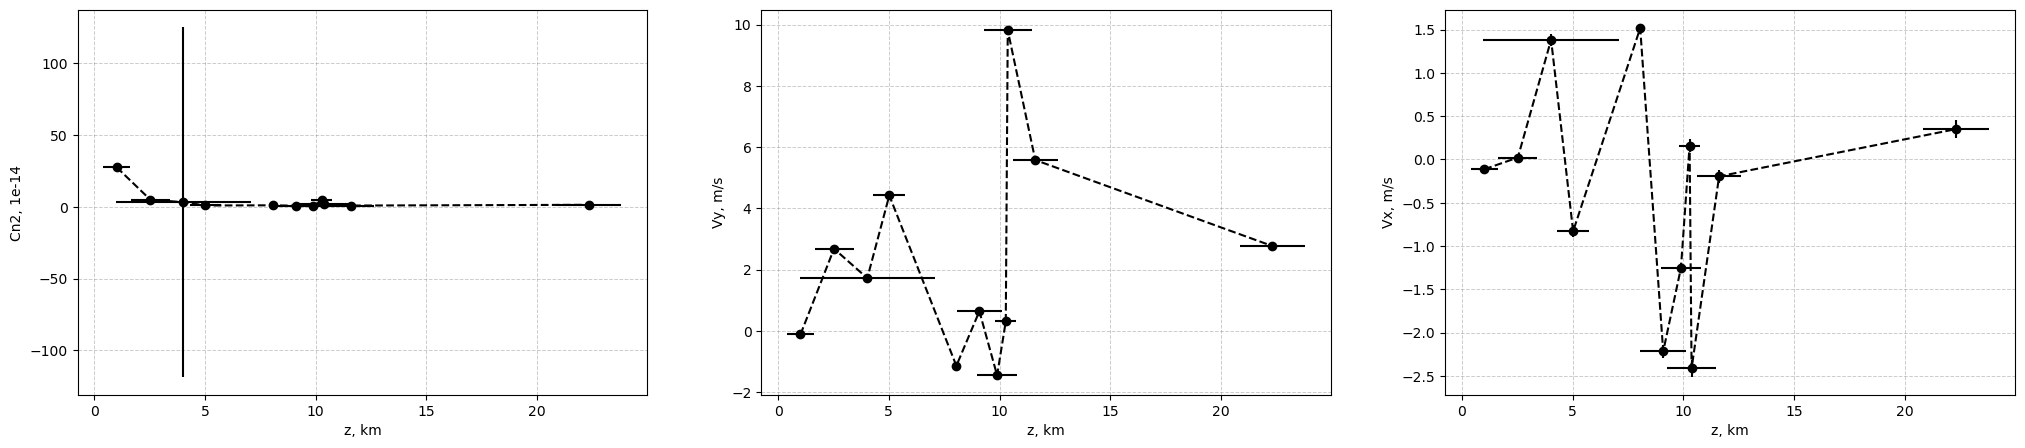

In [6]:
import pandas as pd

df = pd.DataFrame(params, columns = ['Vx','Vy','Cn2', 'z'])
df = df.sort_values(by=['z'])
df_err = pd.DataFrame(errors, columns = ['err_Vx','err_Vy','err_Cn2', 'err_z'])
print(df)
print(df_err)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 

ax.errorbar(df['z'], df['Cn2'], yerr=df_err['err_Cn2'], xerr=df_err['err_z'], fmt='o--', color='black')
ax2.errorbar(df['z'], df['Vy'], yerr=df_err['err_Vy'], xerr=df_err['err_z'], fmt='o--', color='black')
ax3.errorbar(df['z'], df['Vx'], yerr=df_err['err_Vx'], xerr=df_err['err_z'], fmt='o--', color='black')

# ax.plot(df2['z'], df2['Cn2'], 'o--', color='red', label='0 km')
# ax2.plot(df2['z'], df2['Vy'], 'o--', color='red', label='0 km')
# ax3.plot(df2['z'], df2['Vx'], 'o--', color='red', label='0 km')

# ax.legend()
# ax2.legend()
# ax3.legend()

ax.set_ylabel('Cn2, 1e-14')
ax.set_xlabel('z, km')
ax2.set_ylabel('Vy, m/s')
ax2.set_xlabel('z, km')
ax3.set_ylabel('Vx, m/s')
ax3.set_xlabel('z, km')

ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax2.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax3.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

sum_cn2 = np.sum(df['Cn2'])*1e-14
print('Cn2:', sum_cn2)
lambda_ = 500 * pow(10, -9)
r0 = pow(0.423 * pow((2*np.pi/lambda_), 2) * sum_cn2, -3/5)
seeing = 206265 * 0.98 * lambda_/r0
print(seeing)

fig.savefig(f'D:/astro/profile_{file}_{z0}_{latency}.png', bbox_inches='tight')

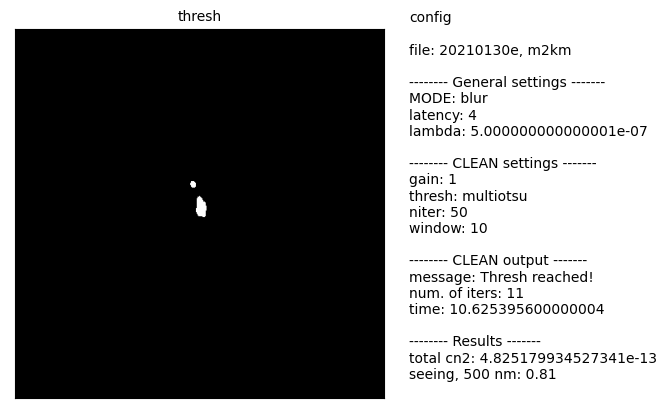

In [7]:
with open(f'D:/astro/config_{file}_{z0}_{latency}.txt', 'w') as f:
    print(f'file: {file}, {z0}km', file=f)
    print('\n-------- General settings -------', file=f)
    print(f'MODE: {gammas_type}', file=f)
    print(f'latency: {latency}', file=f)
    print(f'lambda: {lambda_}', file=f)
    print('\n-------- CLEAN settings -------', file=f)
    print(f'gain: {gain}', file=f)
    print(f'thresh: {thresh_type}', file=f)
    print(f'niter: {niter}', file=f)
    print(f'window: {window}', file=f)
    print('\n-------- CLEAN output -------', file=f)
    print(f'message: {conf[0]}', file=f)
    print(f'num. of iters: {conf[1]}', file=f)
    print(f'time: {conf[2]}', file=f)
    print('\n-------- Results -------', file=f)
    print(f'total cn2: {sum_cn2}', file=f)
    print(f'seeing, 500 nm: {seeing:.2f}', file=f)
    
with open(f'D:/astro/config_{file}_{z0}_{latency}.txt', 'r') as f:
    info = f.read().rstrip('\n')

plt.figure()
plt.imshow(data>thresh, cmap='gray')
plt.text(data.shape[1]+30, data.shape[0]-25, f'config\n\n{info}', fontsize = 10)
plt.xticks([])
plt.yticks([])
plt.title('thresh', fontsize = 10)

plt.savefig(f'D:/astro/thresh_{file}_{z0}_{latency}.png', bbox_inches='tight')


In [4]:
k_height= 20
k_width= 20
R1=np.zeros((k_height, k_width))
R2=np.zeros((k_height, k_width))
h = np.linspace(0, 10, k_height)
c = np.geomspace(1, 1000, k_width)
for i in range(k_height):
    for j in range(k_width):
        R1[i, j] = np.sum(pow(data - gamma_poly_se(X, Y, 0, 0, c[j], h[i]), 2))
        R2[i, j] = np.sum(pow(data - gamma_poly_se(X, Y, 0, 0, c[j], h[i]), 2)[216:236, 216:236])

print('done')

#двумерная карта невязки, где по осям ОУ размечено разбиение по высотам, а по ОХ - разбиение по мощности. в каждой ячейке
# матрицы содержится значение R = sum(data-model)^2. Видно, что при меньшем окне при подсчете суммы, невязка принимает
# правильное значение минимума. В то время как при подсчете в полном окне, минимум явно не прослеживается и поэтому 
# минимизация выдает такое значение

done


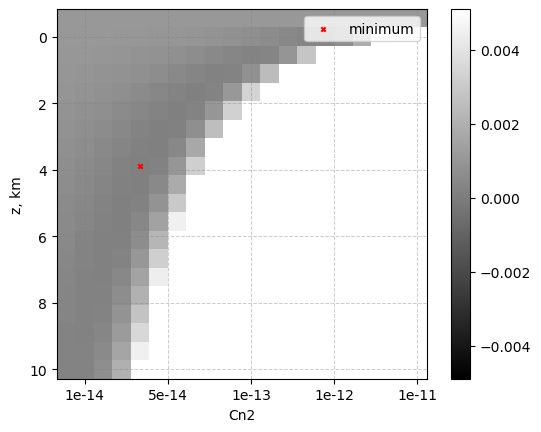

In [21]:
plt.figure()
plt.imshow(R2, vmin=R2[np.unravel_index(np.argmin(R2), R2.shape)]-0.005, 
                       vmax=R2[np.unravel_index(np.argmin(R2), R2.shape)]+0.005, cmap='gray')
plt.colorbar()

plt.scatter(np.unravel_index(np.argmin(R2), R2.shape)[1], np.unravel_index(np.argmin(R2), R2.shape)[0], color='red', s=10, 
            marker='x', label='minimum')

plt.xticks (ticks=np.linspace(0+1, k_width-1, 5), labels=['1e-14', '5e-14', '1e-13', '1e-12', '1e-11'])
plt.yticks (ticks=np.linspace(0+1, k_height-1, 6), labels=['0', '2', '4', '6', '8', '10'])
plt.xlabel('Cn2')
plt.ylabel('z, km')
plt.legend()
plt.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

plt.savefig('D:/astro/R.png', bbox_inches='tight')

blur
0.04547675068231148
3.6362561781154096e-05
full: 0.5263157894736842 6.158482110660264
windowed: 0.0 1.0


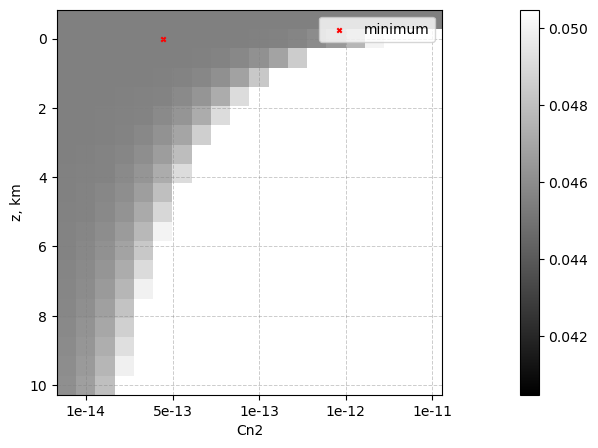

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5)) 
fig.colorbar(ax.imshow(R1, vmin=R1[np.unravel_index(np.argmin(R1), R1.shape)]-0.005, 
                       vmax=R1[np.unravel_index(np.argmin(R1), R1.shape)]+0.005, cmap='gray'), ax=ax)
# fig.colorbar(ax2.imshow(R2, vmin=0,
#                         vmax=0.001, cmap='gray'), ax=ax2)

ax.scatter(np.unravel_index(np.argmin(R1), R1.shape)[1], np.unravel_index(np.argmin(R1), R1.shape)[0], color='red', s=10, 
            marker='x', label='minimum')
# ax2.scatter(np.unravel_index(np.argmin(R2), R2.shape)[1], np.unravel_index(np.argmin(R2), R2.shape)[0], color='red', s=10, 
#             marker='x', label='minimum')

ax.set_xticks (ticks=np.linspace(0+1, k_width-1, 5), labels=['1e-14', '5e-13', '1e-13', '1e-12', '1e-11'])
ax.set_yticks (ticks=np.linspace(0+1, k_height-1, 6), labels=['0', '2', '4', '6', '8', '10'])
ax.set_xlabel('Cn2')
ax.set_ylabel('z, km')
ax.legend()
ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

# ax2.set_xticks (ticks=np.linspace(0+1, k_width-1, 5), labels=['1e-14', '5e-13', '1e-13', '1e-12', '1e-11'])
# ax2.set_yticks (ticks=np.linspace(0+1, k_height-1, 6), labels=['0', '2', '4', '6', '8', '10'])
# ax2.set_xlabel('Cn2')
# ax2.set_ylabel('z, km')
# ax2.legend()
# ax2.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

# fig.savefig(f'D:/astro/R_{gammas_type}.png', bbox_inches='tight')

# ax.set_title('full')
# ax2.set_title('windowed')

print(gammas_type)
print(R1[np.unravel_index(np.argmin(R1), R1.shape)])
print(R2[np.unravel_index(np.argmin(R2), R2.shape)])
print('full:', h[np.unravel_index(np.argmin(R1), R1.shape)[0]], c[np.unravel_index(np.argmin(R1), R1.shape)[1]])
print('windowed:', h[np.unravel_index(np.argmin(R2), R2.shape)[0]], c[np.unravel_index(np.argmin(R2), R2.shape)[1]])